In [1]:
import pandas as pd
import pickle
import re
import numpy as np

In [2]:
INP_PATH = '/data/sherin/'

In [3]:
df_syn = pd.read_pickle(INP_PATH + '/synthetic_inputs.pkl')

In [4]:
# the data in our case is just numbers from 0 to 512 so we will write this in a file
# pre-training a tokenizer - https://www.youtube.com/watch?v=cR4qMSIvX28&ab_channel=JamesBriggs
from tqdm import tqdm

text_data = []

In [5]:
seq = [i for i in df_syn['sequence'].values.tolist()]

In [6]:
with open('tokenizer_file.txt', 'w') as f:
    for a in seq:
        s = " ".join([str(v) for v in a])
        f.write(s)
        f.write("\n")

In [106]:
!pip install tokenizers

In [7]:
from tokenizers import BertWordPieceTokenizer

In [108]:
# Len of vocab in this way is 116
#tokenizer = BertWordPieceTokenizer(clean_text=True)

In [114]:
#tokenizer.train(files='tokenizer_file.txt', vocab_size=520, min_frequency=1, 
#                special_tokens=['[PAD]', '[UNK]', '[CLS]', '[SEP]','[MASK]'], 
#                wordpieces_prefix = '##')
                                                                        

In [115]:
#tokenizer.save_model('./')

['./vocab.txt']

In [8]:
from transformers import BertTokenizer

In [9]:
tokenizer = BertTokenizer.from_pretrained('./')

In [10]:
with open('new_tokenized_data.txt', 'w') as fp:
    for i in range(512):
        fp.write(str(i))
        fp.write('\n')

In [11]:
tokenizer_new = BertWordPieceTokenizer(clean_text=True)

In [12]:
# retain this tokenizer as it has more number of tokens
tokenizer_new.train(files='new_tokenized_data.txt', vocab_size=600, min_frequency=1, 
                special_tokens=['[PAD]', '[UNK]', '[CLS]', '[SEP]','[MASK]'], 
                wordpieces_prefix = '##')

In [13]:
tokenizer_new.save_model('./')

['./vocab.txt']

In [14]:
with open('./vocab.txt', 'r') as fp:
    vocab = fp.read().split('\n')

In [15]:
len(vocab)

528

In [16]:
tokenizer = BertTokenizer.from_pretrained('./')

In [17]:
tokenizer('10 20 30')

{'input_ids': [2, 32, 42, 52, 3], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [18]:
mask_token_id = tokenizer.convert_tokens_to_ids('[MASK]')

In [19]:
# MLM training pipeline
#https://www.youtube.com/watch?v=heTYbpr9mD8&list=PLIUOU7oqGTLj-k75kkirRrCybsJzCKCJW&index=3&ab_channel=JamesBriggs
#https://towardsdatascience.com/how-to-train-a-bert-model-from-scratch-72cfce554fc6
import torch
def MaskLanguageModelling(t):
    rand = torch.rand(t.shape)
    masks = (rand < 0.15)*(t > 2)
    for i in range(t.shape[0]):
        selection = torch.flatten(masks[i].nonzero()).tolist()
        t[i, selection] = mask_token_id
    return t

In [173]:
# the masked input will be in input_ids, you also need to specify the attention mask using mask, and labels which
# are the actual input ids without masking
input_ids = []
mask = []
labels = []

# all the inputs are in 'tokenized_file.txt'
with open('tokenizer_file.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

sample = tokenizer(lines, max_length=512, padding='max_length', truncation=True, return_tensors='pt')


In [176]:
labels.append(sample.input_ids)
mask.append(sample.attention_mask)
input_ids.append(MaskLanguageModelling(sample.input_ids.detach().clone()))

In [177]:
input_ids = torch.cat(input_ids)
mask = torch.cat(mask)
labels = torch.cat(labels)

In [181]:
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}

In [182]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

In [183]:
dataset = Dataset(encodings)

In [184]:
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [20]:
from transformers import BertConfig

config = BertConfig(
    vocab_size=tokenizer.vocab_size,  # we align this to the tokenizer vocab_size
    max_position_embeddings=514,
    hidden_size=512,
    num_attention_heads=4,
    num_hidden_layers=2,
    type_vocab_size=1
)

In [21]:
from transformers import BertForMaskedLM

model_bert = BertForMaskedLM(config)

In [324]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)

RetentionNetwork(
  (linear): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
  )
  (model_bert): BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(527, 768, padding_idx=0)
        (position_embeddings): Embedding(514, 768)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfO

In [22]:
device

NameError: name 'device' is not defined

In [326]:
from transformers import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)

/opt/conda/envs/tf14/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [36]:
checkpoint_path = '/data/sherin/checkpoint_lm/chkpt_synthetic_bert_best.pt.tar'

In [328]:
epochs = 2
min_loss = np.inf

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    if loss.item() < min_loss:
        print("saving best model")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
        }, checkpoint_path)
        min_loss = loss.item()
    else:
        print("not saving the model")

  0%|                                                 | 0/12109 [00:00<?, ?it/s]


TypeError: forward() got an unexpected keyword argument 'attention_mask'

In [23]:
# convert the context and query to be string
def convert_to_string(df, col_name):
    seq = df[col_name].tolist()
    return " ".join([str(a) for a in seq])

In [24]:
# convert the context and query to be string
def convert_query(df, col_name):
    return(str(df[col_name]))


In [25]:
df_syn['seq_str'] = df_syn.apply(lambda x: convert_to_string(x, 'sequence'), axis=1)
df_syn['query_str'] = df_syn.apply(lambda x: convert_query(x, 'query'), axis=1)

In [26]:
df_exp = df_syn.tail()

In [259]:
df_exp

,sequence,query,sequence_len,first_rep_pos,label,token_repeated,seq_str,query_str
193730,"[1, 13, 29, 12, 11, 88, 0, 48, 46, 87, 86, 76,...",94,99,-1,0,-1,1 13 29 12 11 88 0 48 46 87 86 76 3 7 95 50 71...,94
193731,"[55, 60, 11, 90, 18, 38, 9, 87, 35, 30, 6, 48,...",4,99,46,1,4,55 60 11 90 18 38 9 87 35 30 6 48 41 16 77 57 ...,4
193732,"[53, 54, 1, 44, 48, 79, 15, 47, 23, 58, 97, 33...",42,99,-1,0,-1,53 54 1 44 48 79 15 47 23 58 97 33 29 78 26 91...,42
193733,"[36, 30, 49, 66, 52, 7, 79, 37, 62, 9, 59, 27,...",69,99,16,1,69,36 30 49 66 52 7 79 37 62 9 59 27 85 72 12 97 ...,69
193734,"[0, 84, 62, 7, 5, 18, 40, 63, 32, 68, 87, 66, ...",72,99,-1,0,-1,0 84 62 7 5 18 40 63 32 68 87 66 93 90 13 8 37...,72


In [260]:
df_exp.head().iloc[:,7]

193730    94
193731     4
193732    42
193733    69
193734    72
Name: query_str, dtype: object

In [27]:
# create a dataset with the dataframe
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

    def __init__(self, dataframe):

        self.context = dataframe.iloc[:, 6]
        self.query = dataframe.iloc[:,7]
        self.labels = dataframe.iloc[:, 4]

        #self.x_train=torch.tensor(x,dtype=torch.float32)
        #self.y_train=torch.tensor(y,dtype=torch.float32)

    def __len__(self):
        return len(self.query)
  
    def __getitem__(self, idx):
        #print(self.query[idx], self.labels[idx])
        return self.context.iloc[idx], self.query.iloc[idx], self.labels.iloc[idx]

In [28]:
from torch.utils.data import random_split

data_set = CustomDataset(df_syn)

# split the dataset into train(80%), validation(10%), and test(10%)
train_len = int(len(df_syn)*0.8)
test_len = int(len(df_syn)*0.1)
val_len = len(df_syn) - train_len - test_len
train_set, val_set, test_set = random_split(data_set, [train_len, val_len, test_len])


train_loader = DataLoader(train_set,batch_size=128,shuffle=True)
test_loader = DataLoader(test_set,batch_size=128,shuffle=False)
val_loader = DataLoader(val_set,batch_size=128,shuffle=False) 

In [29]:
from torch import nn

In [30]:
class RetentionNetwork(nn.Module):
    def __init__(self):
        super(RetentionNetwork, self).__init__()
        
        self.linear = nn.Sequential(
            # 384 is the size of the embedding
            #nn.Linear(768, 768)
            nn.Linear(512, 512, bias=False)
        )
        self.model_bert = BertForMaskedLM(config)

    def forward(self, x, y):
        #print(x.size())
        x_tok = tokenizer(x, return_tensors="pt", truncation=True, padding=True).to(device)
        x_bert = self.model_bert(**x_tok, output_hidden_states=True)
        #print(len(x_bert.hidden_states))
        x_bert_rep = x_bert.hidden_states[-1][:,0,:]
        y_tok = tokenizer(y, return_tensors="pt", truncation=True, padding=True).to(device)
        y_op = self.model_bert(**y_tok, output_hidden_states=True)
        y_op_rep = y_op.hidden_states[-1][:,1,:]
        x_op = self.linear(x_bert_rep)
        #print(x_input.size())
        #print(y.size())
        op = torch.sum(x_op*y_op_rep, dim=1)
        #print(op.shape)
        return op

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = RetentionNetwork().to(device)
print(model)

RetentionNetwork(
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=False)
  )
  (model_bert): BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(527, 512, padding_idx=0)
        (position_embeddings): Embedding(514, 512)
        (token_type_embeddings): Embedding(1, 512)
        (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=512, out_features=512, bias=True)
                (key): Linear(in_features=512, out_features=512, bias=True)
                (value): Linear(in_features=512, out_features=512, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelf

In [33]:
model.model_bert.cls

BertOnlyMLMHead(
  (predictions): BertLMPredictionHead(
    (transform): BertPredictionHeadTransform(
      (dense): Linear(in_features=512, out_features=512, bias=True)
      (transform_act_fn): GELUActivation()
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    )
    (decoder): Linear(in_features=512, out_features=527, bias=True)
  )
)

In [357]:
for name, param in model.named_parameters():
        print("{} {}".format(name, param.requires_grad))

linear.0.weight True
model_bert.bert.embeddings.word_embeddings.weight True
model_bert.bert.embeddings.position_embeddings.weight True
model_bert.bert.embeddings.token_type_embeddings.weight True
model_bert.bert.embeddings.LayerNorm.weight True
model_bert.bert.embeddings.LayerNorm.bias True
model_bert.bert.encoder.layer.0.attention.self.query.weight True
model_bert.bert.encoder.layer.0.attention.self.query.bias True
model_bert.bert.encoder.layer.0.attention.self.key.weight True
model_bert.bert.encoder.layer.0.attention.self.key.bias True
model_bert.bert.encoder.layer.0.attention.self.value.weight True
model_bert.bert.encoder.layer.0.attention.self.value.bias True
model_bert.bert.encoder.layer.0.attention.output.dense.weight True
model_bert.bert.encoder.layer.0.attention.output.dense.bias True
model_bert.bert.encoder.layer.0.attention.output.LayerNorm.weight True
model_bert.bert.encoder.layer.0.attention.output.LayerNorm.bias True
model_bert.bert.encoder.layer.0.intermediate.dense.weigh

In [34]:
import torch.optim as optim
import torchmetrics

#criterion = nn.functional.binary_cross_entropy()
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
epoch_loss_list = []
accuracy_list = []
val_loss_list = []
val_acc_list = []
valid_acc_max = 0 

for epoch in range(2):  # loop over the dataset multiple times
    train_count = 0
    model.train()
    epoch_loss = 0.0
    accuracy = 0.0
    
    #for ind in tqdm(range(len(df_short)))
    for c, q, labels in tqdm(train_loader):
        train_count = train_count+1
        #context = torch.tensor(model_sent_trans.encode(list(c))).to(device)
        #context = get_rep(c, is_context=True)
        #print(context.size())
        
        #query = torch.tensor(model_sent_trans.encode(list(q))).to(device)
        #query = get_rep(q, is_context=False)
        
        target = labels.to(device)
        #label = torch.tensor(labels.float()).to(device)
        label = labels.float().to(device)
        #print(context.size())
        #print(query.size())     
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(c, q)
        #loss = criterion(outputs, labels)
        loss = criterion(outputs, label)
        loss.backward()

        optimizer.step()
        #print(loss.item())
        # print statistics
        #running_loss += loss.item()
        epoch_loss += loss.item()
        accuracy += torchmetrics.functional.accuracy(outputs, target, threshold=0.5).item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #running_loss = 0.0
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    
    test_count = 0
    for c, q, labels in tqdm(val_loader):
        test_count = test_count + 1
        #context = get_rep(c, is_context=True)
        #query = get_rep(q, is_context=False)

        target = labels.to(device)
        label = labels.float().to(device)
        
        outputs = model(c, q)
        loss = criterion(outputs, label)
        val_loss += loss.item()
        val_acc += torchmetrics.functional.accuracy(outputs, target, threshold=0.5).item()
        
    accuracy = accuracy / train_count
    epoch_loss = epoch_loss / train_count
    val_loss = val_loss / test_count
    val_acc = val_acc / test_count
    
    if val_acc > valid_acc_max:
        print("saving best model")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc,
            }, checkpoint_path)
        val_acc_max = val_acc
    else:
        print("not saving the model")
    
    print(f'[{epoch + 1}, {i + 1:5d}] Training loss: {epoch_loss:.3f} Training accuracy : {accuracy:.3f}')
    print(f'[{epoch + 1}, {i + 1:5d}] Validation loss: {val_loss:.3f} Validation accuracy : {val_acc:.3f}')
    epoch_loss_list.append(epoch_loss)
    accuracy_list.append(accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

print('Finished Training')

100%|█████████████████████████████████████████| 152/152 [00:17<00:00,  8.49it/s]

saving best model


NameError: name 'checkpoint_path' is not defined

In [335]:
print("Finished training")

Finished training


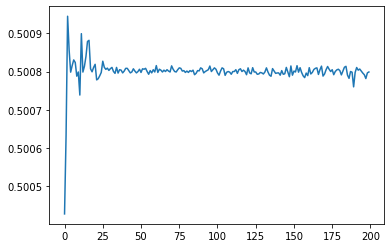

In [336]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list)

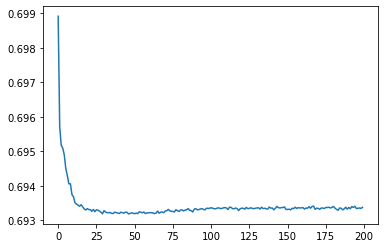

In [348]:
plt.plot(epoch_loss_list)

In [339]:
model = model = RetentionNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
PATH = checkpoint_path
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# inferece
model.eval()

RetentionNetwork(
  (linear): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
  )
  (model_bert): BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(527, 512, padding_idx=0)
        (position_embeddings): Embedding(514, 512)
        (token_type_embeddings): Embedding(1, 512)
        (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=512, out_features=512, bias=True)
                (key): Linear(in_features=512, out_features=512, bias=True)
                (value): Linear(in_features=512, out_features=512, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfO

In [341]:
test_count = 0
output_logits = []
for c, q, labels in tqdm(test_loader):

    target = labels.to(device)
    label = labels.float().to(device)
    outputs = model(c, q).detach().cpu().numpy()
        
    outputs = model(c, q).detach().cpu().numpy()
    output_logits.append(outputs)

100%|███████████████████████████████████████| 152/152 [00:34<00:00,  4.43it/s]


In [343]:
epoch

199

In [344]:
val_acc_list[199]

0.5001385513889162